# Setup

Dhrumil's standard Python + R Setup. This setup allows me to use python and R in the same notebook. 

See https://github.com/data4news/jupyter-quickstart for details.

In [34]:
# %reload_ext rpy2.ipython
%reload_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
# from rpy2.rinterface import RRuntimeWarning
# warnings.filterwarnings("ignore", category=RRuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML
from datetime import datetime, date, timedelta
from tqdm.notebook import tqdm
## import os; os.makedirs('output', exist_ok=True)

Install new mediacloud client (you may need to uninstall the old one if you have it already) and the wayback-news-search client.

In [35]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## New MediaCloud

In [36]:
import datetime as dt
from waybacknews.searchapi import SearchApiClient

In [37]:
from mediacloud import api

# Query parameters
query_term = "Greece"
start =  datetime(2025, 1, 1)
end = datetime(2025, 8, 29)
language = "en"

domains = ['nytimes.com','cnn.com','foxnews.com','nypost.com','washingtonpost.com','usatoday.com','cnbc.com',
              'theguardian.com','breakingnews.com','buzzfeed.com','cbsnews.com','reuters.com','huffingtonpost.com',
              'usnews.com','latimes.com','politico.com','newsweek.com','breitbart.com',]
domains_str = f"domain:({' OR '.join(domains)})"

query = f"{query_term} AND language:{language} AND {domains_str}"
query

'Greece AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)'

In [38]:
import json
import os

# Ensure the output directory exists
os.makedirs('output', exist_ok=True)

# Save Metadata
metadata = {
    "start": start.isoformat(), 
    "end": end.isoformat(),
    "query": query_term,
    "query_raw": query
}

# Save to json file
with open('output/metadata.json', 'w') as fp:
    json.dump(metadata, fp)

In [39]:
# Instantiate API
api = SearchApiClient("mediacloud")

In [40]:
# Run Summary Queries
count   = api.count(query, start, end)
sources = api.top_sources(query, start, end)
tlds    = api.top_tlds(query, start, end)

In [41]:
# Display Query
pattern = '%B %d, %Y %H:%M'
display(HTML("<h3>Query</h3>"))
print(query)
print(f"{start.strftime(pattern)} - {end.strftime(pattern)}")

# Display Summaries of Results
n = 25
display(HTML("<h3>Summary of results</h3>"))
print(f"Found {count} articles\n")
display(pd.DataFrame(sources).head(n).style.set_caption(f"Top {n} sources"))
display(pd.DataFrame(tlds).head(n).style.set_caption(f"Top {n} tlds"))

Greece AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)
January 01, 2025 00:00 - August 29, 2025 00:00


Found 1787 articles



,name,value
0,nytimes.com,504
1,theguardian.com,361
2,buzzfeed.com,140
3,cbsnews.com,117
4,cnn.com,117
5,nypost.com,96
6,usatoday.com,87
7,newsweek.com,76
8,breitbart.com,74
9,foxnews.com,68


,name,value
0,com,1787


### Get counts over time

In [42]:
counts_over_time = pd.DataFrame(api.count_over_time(query, start, end))


In [43]:
counts_over_time.to_csv('output/counts_over_time.csv', index=False)

In [44]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R

require('tidyverse')

[1] "Greece AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)"


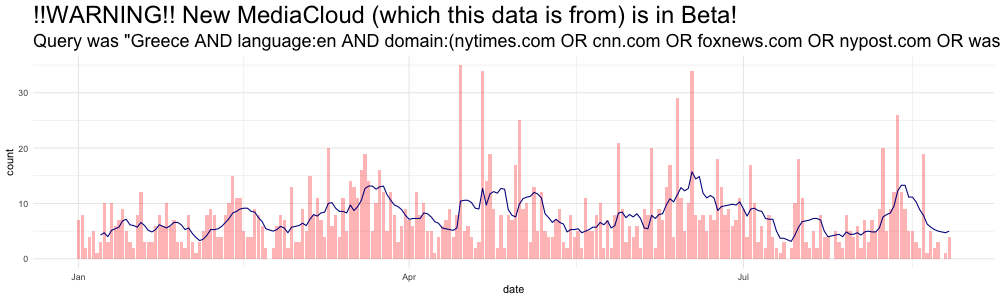

In [46]:
%%R -w 1000 -h 300 -i query

require('tidyquant')

counts_over_time <- read_csv('output/counts_over_time.csv', show_col_types = FALSE)

plt <- ggplot(counts_over_time) +
    aes(x=date, y=count) +
    geom_col(alpha=.3, fill="red") +
    geom_ma(ma_fun = SMA, n = 7, linetype='solid') +
    theme_minimal() +
    labs(
        subtitle=paste0("Query was \"",query,"\""),
        title="!!WARNING!! New MediaCloud (which this data is from) is in Beta! "
    ) +
    theme(
        plot.title = element_text(size=24),
        plot.subtitle = element_text(size=18))

print(plt)
print(query)

### Get actual articles

In [47]:
query 

'Greece AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)'

In [48]:
article_generator = api.all_articles(query, start, end)

In [49]:
# TODO: Add a progress bar
# took 1m 4.6s for 37998 articles 
# ChatGPT AND language:en from (2022-11-01 to 2023-3-23)
articles = []
for list_of_articles in article_generator:
    articles += list_of_articles    

print(f"all_articles endpoint: {len(articles)} articles")
print(f"count endpoint: {count} articles")

all_articles endpoint: 1787 articles
count endpoint: 1787 articles


In [50]:
stories = pd.DataFrame(articles)\
        .sort_values(by='publication_date', ascending=False)

stories.to_csv('output/stories_df.csv', index=False)

stories

,title,publication_date,capture_time,language,domain,url,original_capture_url,archive_playback_url,article_url
1006,Fears of a French Government Collapse Send Its...,2025-08-26,2025-08-27T02:36:31Z,en,nytimes.com,https://www.nytimes.com/2025/08/26/business/fr...,https://web.archive.org/web/20250827023631id_/...,https://web.archive.org/web/20250827023631/htt...,https://wayback-api.archive.org/colsearch/v1/m...
1162,"The Transfer DealSheet: Latest on Man Utd, Ars...",2025-08-26,2025-08-26T09:52:23Z,en,nytimes.com,https://www.nytimes.com/athletic/6573666/2025/...,https://web.archive.org/web/20250826095223id_/...,https://web.archive.org/web/20250826095223/htt...,https://wayback-api.archive.org/colsearch/v1/m...
445,"In Turkey, your coffee comes with a side of de...",2025-08-26,2025-08-27T10:28:36Z,en,cnn.com,https://www.cnn.com/2025/08/26/travel/turkey-c...,https://web.archive.org/web/20250827102836id_/...,https://web.archive.org/web/20250827102836/htt...,https://wayback-api.archive.org/colsearch/v1/m...
94,29 Pairs Of Sandals For Anyone Who Refuses To ...,2025-08-26,2025-08-27T10:14:08Z,en,buzzfeed.com,https://www.buzzfeed.com/cierracowan/pairs-san...,https://web.archive.org/web/20250827101408id_/...,https://web.archive.org/web/20250827101408/htt...,https://wayback-api.archive.org/colsearch/v1/m...
1161,"Garnacho, Jackson, Zinchenko and the other pla...",2025-08-25,2025-08-25T09:43:18Z,en,nytimes.com,https://www.nytimes.com/athletic/6568993/2025/...,https://web.archive.org/web/20250825094318id_/...,https://web.archive.org/web/20250825094318/htt...,https://wayback-api.archive.org/colsearch/v1/m...
...,...,...,...,...,...,...,...,...,...
1013,What will Thomas Tuchel do on his first day as...,2025-01-01,2025-01-02T04:04:39Z,en,nytimes.com,https://www.nytimes.com/athletic/6021619/2025/...,https://web.archive.org/web/20250102040439id_/...,https://web.archive.org/web/20250102040439/htt...,https://wayback-api.archive.org/colsearch/v1/m...
716,Ukraine halts Russian gas supplies to Europe a...,2025-01-01,2025-01-02T03:29:41Z,en,nypost.com,https://nypost.com/2025/01/01/world-news/ukrai...,https://web.archive.org/web/20250102032941id_/...,https://web.archive.org/web/20250102032941/htt...,https://wayback-api.archive.org/colsearch/v1/m...
715,Country with the world’s best cuisine named — ...,2025-01-01,2025-01-02T17:55:25Z,en,nypost.com,https://nypost.com/2025/01/01/lifestyle/this-c...,https://web.archive.org/web/20250102175525id_/...,https://web.archive.org/web/20250102175525/htt...,https://wayback-api.archive.org/colsearch/v1/m...
1760,Cheap vacation tip: 7 budget-friendly European...,2025-01-01,2025-01-03T11:28:39Z,en,usatoday.com,https://www.usatoday.com/story/travel/news/202...,https://web.archive.org/web/20250103112839id_/...,https://web.archive.org/web/20250103112839/htt...,https://wayback-api.archive.org/colsearch/v1/m...


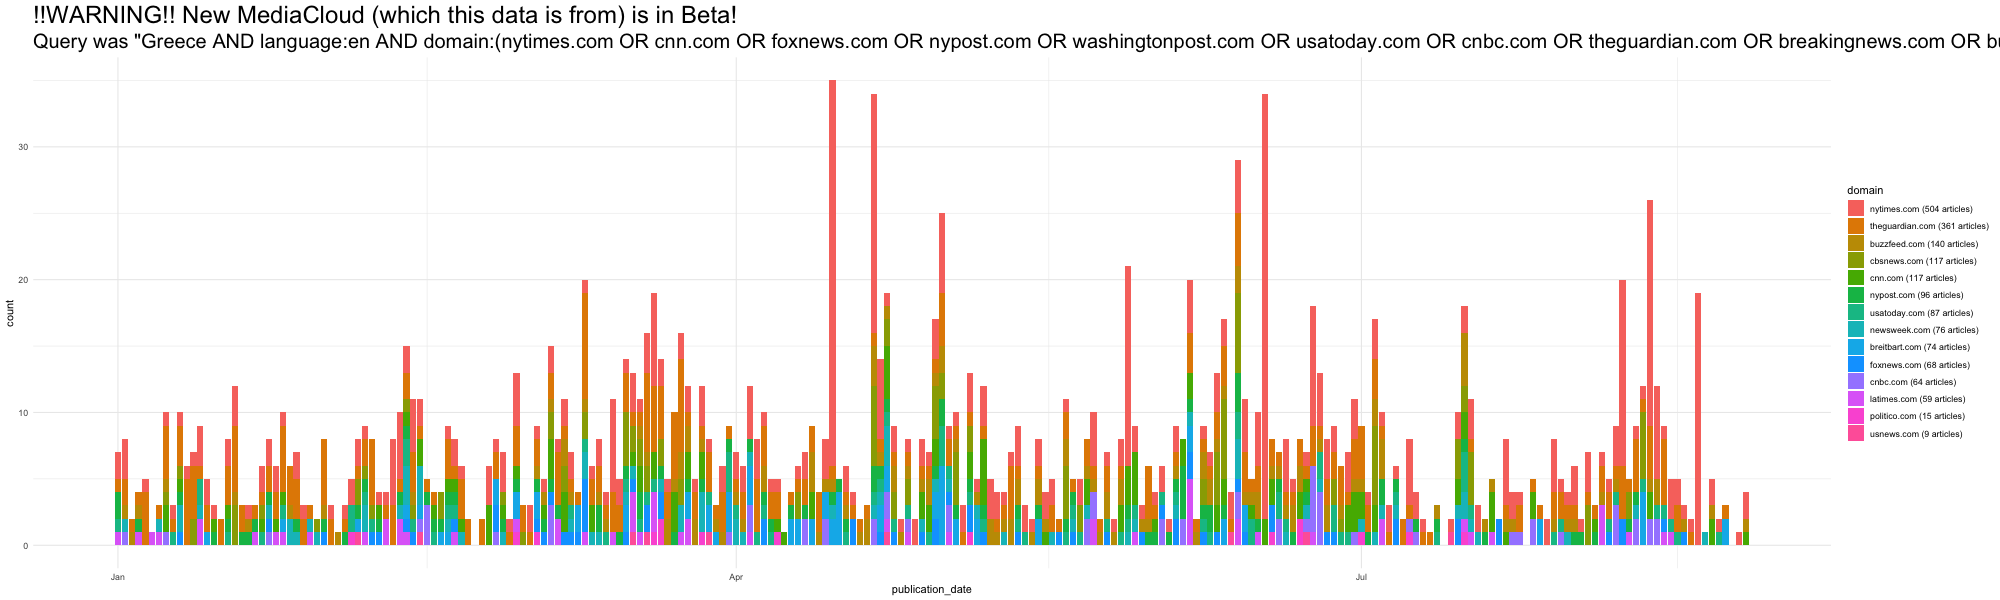

In [51]:
%%R -w 2000 -h 600 

stories_df <- read_csv('output/stories_df.csv', show_col_types = FALSE)
domain_order <- stories_df %>% group_by(domain) %>% summarise(count=n()) %>% arrange(desc(count))
domain_order$label <- paste0(domain_order$domain, ' (', domain_order$count,' articles)') 
stories_df$domain <- factor(stories_df$domain, levels=domain_order$domain, labels=domain_order$label)


ggplot(stories_df) +
    aes(x=publication_date, fill=domain) +
    geom_bar() +
    theme_minimal() +
    labs(
        subtitle=paste0("Query was \"",query,"\""),
        title="!!WARNING!! New MediaCloud (which this data is from) is in Beta! "
    ) +
    theme(
        plot.title = element_text(size=24),
        plot.subtitle = element_text(size=20),
        strip.text = element_text(size=18))

`summarise()` has grouped output by 'domain'. You can override using the
`.groups` argument.


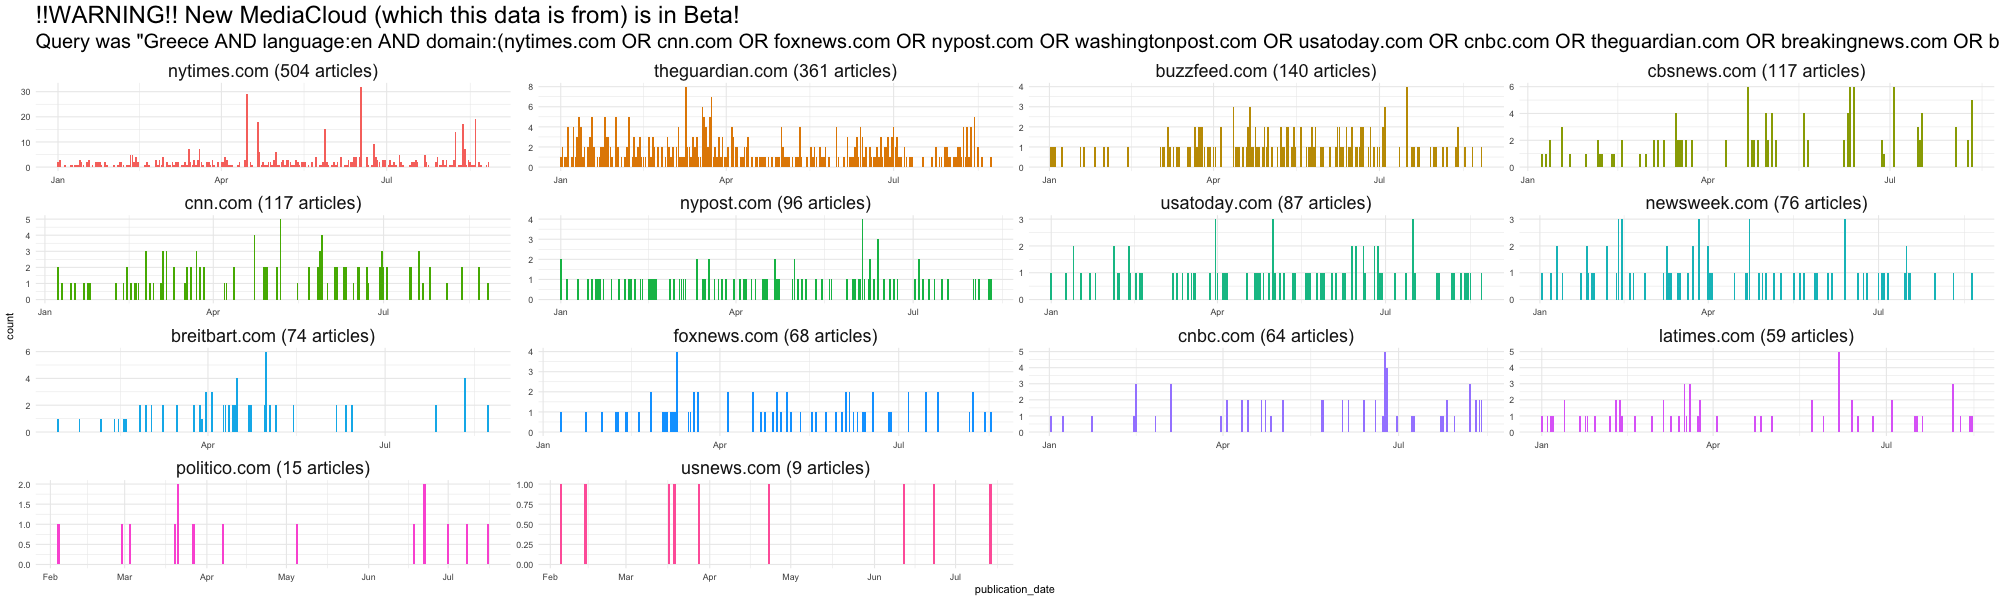

In [52]:
%%R -w 2000 -h 600 

stories_df <- read_csv('output/stories_df.csv', show_col_types = FALSE)
domain_order <- stories_df %>% group_by(domain) %>% summarise(count=n()) %>% arrange(desc(count))
domain_order$label <- paste0(domain_order$domain, ' (', domain_order$count,' articles)') 
stories_df$domain <- factor(stories_df$domain, levels=domain_order$domain, labels=domain_order$label)

stories_df_2 <- stories_df %>% group_by(domain, publication_date) %>% summarise(count=n()) %>% arrange(desc(count))
ggplot(stories_df_2) +
    aes(x=publication_date, y=count, fill=domain) +
    geom_col() +
    facet_wrap(~domain, scales='free') +
    theme_minimal() +
    labs(
        subtitle=paste0("Query was \"",query,"\""),
        title="!!WARNING!! New MediaCloud (which this data is from) is in Beta! "
    ) +
    theme(
        plot.title = element_text(size=24),
        plot.subtitle = element_text(size=20),
        strip.text = element_text(size=18),
        legend.position="none")

In [53]:
import requests_cache
session = requests_cache.CachedSession('mediacloud_cache')

from tqdm.autonotebook import tqdm
tqdm.pandas()

# retrying
from retrying import retry
stories = pd.read_csv('output/stories_df.csv')

@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def get_snippet(url):
    return session.get(url).json()['snippet']

stories['snippet'] = stories['article_url'].progress_apply(get_snippet)

  0%|          | 0/1787 [00:00<?, ?it/s]

In [54]:
# Stories with full text of articles!!!!
stories_df = pd.DataFrame(stories)
stories_df.to_csv('output/stories_df.csv', index=False)
stories_df.sample(4)

,title,publication_date,capture_time,language,domain,url,original_capture_url,archive_playback_url,article_url,snippet
967,Pope Francis Has Died At Age 88,2025-04-21,2025-04-23T04:00:31Z,en,buzzfeed.com,https://www.buzzfeed.com/antoniablumberg/pope-...,https://web.archive.org/web/20250423040031id_/...,https://web.archive.org/web/20250423040031/htt...,https://wayback-api.archive.org/colsearch/v1/m...,"Pope Francis, the 266th leader of the Roman Ca..."
1022,Update from Alan Feuer,2025-04-15,2025-04-16T03:37:55Z,en,nytimes.com,https://www.nytimes.com/live/2025/04/15/us/tru...,https://web.archive.org/web/20250416033755id_/...,https://web.archive.org/web/20250416033755/htt...,https://wayback-api.archive.org/colsearch/v1/m...,Trump Administration Live Updates: Judge Scold...
1531,US releases Russian cybercriminal as part of e...,2025-02-13,2025-02-16T05:03:57Z,en,theguardian.com,https://www.theguardian.com/us-news/2025/feb/1...,https://web.archive.org/web/20250216050357id_/...,https://web.archive.org/web/20250216050357/htt...,https://wayback-api.archive.org/colsearch/v1/m...,The Trump administration has released Alexande...
570,The U.S. spends $1 trillion a year to service ...,2025-06-11,2025-06-13T03:43:15Z,en,cbsnews.com,https://www.cbsnews.com/amp/miami/news/trump-b...,https://web.archive.org/web/20250613034315id_/...,https://web.archive.org/web/20250613034315/htt...,https://wayback-api.archive.org/colsearch/v1/m...,The U.S. spends $1 trillion a year to service ...
